In [1]:
# ライブラリ読み込み
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pronto
import copy
import networkx as nx
import os
import pickle
import glob
import gzip
from tqdm.notebook import tqdm
import itertools
#from collections import OrderedDict
#import collections
#from collections import Counter

In [2]:
#current

os.chdir("/home/admin_user/デスクトップ/UMLS2021AB")
#file_1 : pronto.Ontology.from_obo_library("hp.obo")
file_2 = "phenotype.hpoa"
file_3 = "CTD_diseases.tsv.gz"
file_4 = "MRFILES.RRF.gz"
file_5 = "MRSTY.RRF.gz"
file_6 = "MRCONSO.RRF.aa.gz"
file_7 = "MRCONSO.RRF.ab.gz"
file_8 = "SRFIL"

In [3]:
#HPOオントロジー
#'hp.obo'読み込み　タームを取り出す
ont = pronto.Ontology.from_obo_library("hp.obo")
#保存
with open("hp_20220201.obo", "wb") as f:
    ont.dump(f, format="obo")
len(ont)

/home/admin_user/anaconda3/lib/python3.8/site-packages/pronto/ontology.py:206: UnicodeWarning: unsound encoding, assuming ISO-8859-1 (73% confidence)
  return cls(


16601

In [4]:
#HPOオントロジー中で XREFにUMLSを持つもの(UMLSへのマッピングの数)

hp=[]
umls = []
hp_umls=[]
hp_cui = []

for term in ont.terms():
    for each_xref in term.xrefs:
        if ("Xref('UMLS:" in str(each_xref)):
            cui = str(each_xref).replace("Xref('UMLS:", "").replace("')", "")
            hp.append(term.id) #HPO_id
            umls.append( cui) #CUI
            hp_umls.append([term.id, cui]) #HPO_id, CUI
            hp_cui.append([term.name + '(' + term.id + ')', term.id, cui]) #HPO_id, HPO_name, CUI
                
hp = sorted(list(set(hp)))
umls = sorted(list(set(umls)))
hp_umls = sorted(list(map(list, set(map(tuple, hp_umls)))))
hp_cui = sorted(list(map(list, set(map(tuple, hp_cui)))))

print("HPの数:", len(hp), "CUIの数:", len(umls), "マッピングの数:", len(hp_umls) ,len(hp_cui) )

#廃止タームを除外  HPの数: 11599 CUIの数: 12867 マッピングの数: 13016

HPの数: 11600 CUIの数: 12868 マッピングの数: 13017 13017


In [5]:
#'phenotype.hpoa'読み込み
print(file_2)
phenotype_df = pd.read_csv(file_2, header=4, sep="\t", engine="python")
#列名#DatabaseIDをOMIM に絞る
phenotype_df = phenotype_df[phenotype_df["#DatabaseID"].str.contains("OMIM")]
phenotype_df = phenotype_df.rename(columns={'#DatabaseID': "OMIM", "HPO_ID":"HP"})
phenotype_df = phenotype_df[["HP", "OMIM"]]
print("hpoaのアノテーション総数:", len(phenotype_df))
print("hpoaのOMIMの種類数:", phenotype_df["OMIM"].nunique())
print("hpoaのHPOの種類数:", phenotype_df["HP"].nunique())

phenotype.hpoa
hpoaのアノテーション総数: 120331
hpoaのOMIMの種類数: 8120
hpoaのHPOの種類数: 8041


In [6]:
#phenotype.hpoaにあるHPOのCUIマッピング

#XREFにUMLSを持つHPO
hp_df = pd.DataFrame(hp, columns=["HP"]) 
#phenotype_dfと合わせる
print("phenotype.hpoaにあるHPOからのCUIマッピング:", len(pd.merge(phenotype_df, hp_df)))
print("そのHPOの数:", pd.merge(phenotype_df, hp_df)["HP"].nunique())
print("そのOMIMの数:", pd.merge(phenotype_df, hp_df)["OMIM"].nunique())

phenotype.hpoaにあるHPOからのCUIマッピング: 117950
そのHPOの数: 7125
そのOMIMの数: 8120


In [7]:
#CTD

In [8]:
print(file_3) #2011検証と共通
all_ctd = pd.read_csv(file_3, sep='\t', header=27)
all_ctd = all_ctd[1:]
print("CTDレコード件数:", len(all_ctd))

#ctd = ctd.rename(columns={"# DiseaseName": "DiseaseName"}) #列名変更
ctd = all_ctd[["DiseaseID", "AltDiseaseIDs"]] #列を限定（→重複データなし ctd[~ctd.duplicated()]）
#DAltDiseaseIDsを持つものに限定
ctd = ctd[ctd["AltDiseaseIDs"].notna()]
ctd = ctd.reset_index(drop=True)
print("AltDiseaseIDsを持つレコード件数:", len(ctd))



CTD_diseases.tsv.gz
CTDレコード件数: 13144
AltDiseaseIDsを持つレコード件数: 6595


In [9]:
#DiseaseIDかAltDiseaseIDs に MESHかOMIMを持つレコードを探し、そのインデックス番号を取得

#"MESH:D" 

#「MeSH」
m_o_map_index = [ enu for enu, i in enumerate(ctd.values.tolist()) if (("MESH:D" in i[0]) & ("OMIM" in i[1])) | (("OMIM" in i[0]) & ("MESH:D" in i[1]))]

#インデックス番号でctdをサイズダウン
m_o_map = ctd.iloc[m_o_map_index]
m_o_map = m_o_map.reset_index(drop=True)
print(len(m_o_map))

#AltDiseaseIDs列のデータを要素に分割
m_o_map["AltDiseaseIDs"] = m_o_map["AltDiseaseIDs"].str.split("|")

633


#DiseaseIDかAltDiseaseIDs に MESHかOMIMを持つレコードを探し、そのインデックス番号を取得

#「MeSH」
m_o_map_index = [ enu for enu, i in enumerate(ctd.values.tolist()) if (("MESH" in i[0]) & ("OMIM" in i[1])) | (("OMIM" in i[0]) & ("MESH" in i[1]))]

#インデックス番号でctdをサイズダウン
m_o_map = ctd.iloc[m_o_map_index]
m_o_map = m_o_map.reset_index(drop=True)
print(len(m_o_map)) #3330

#AltDiseaseIDs列のデータを要素に分割
m_o_map["AltDiseaseIDs"] = m_o_map["AltDiseaseIDs"].str.split("|")

In [10]:
#m_o_mapは DiseaseID(MESH)：AltDiseaseIDs(他)＝１：n なので, DiseaseID(MESH)：AltDiseaseIDs(OMIM)=１：１に絞り込む
each_m_o_map = [ [m_o[0], each_id] for m_o in m_o_map.values.tolist() for each_id in m_o[1] if "OMIM" in each_id ]
each_m_o_map_df = pd.DataFrame(each_m_o_map, columns=["MESH", "OMIM"])
print("MESH")
print("MeSH-OMIMマッピングの数:", len(each_m_o_map_df))
print("MESHの数:", len(each_m_o_map_df["MESH"].unique()))
print("OMIMの数:", len(each_m_o_map_df["OMIM"].unique()))
#MESH
#MeSH-OMIMマッピングの数: 4051
#MESHの数: 3330
#OMIMの数: 4051


MESH
MeSH-OMIMマッピングの数: 1154
MESHの数: 633
OMIMの数: 1154


In [11]:
ctd = each_m_o_map_df

In [12]:
print("phenotype.hpoaのアノテーション総数:", len(phenotype_df), "HP:", phenotype_df["HP"].nunique(), "OMIM:", phenotype_df["OMIM"].nunique() )
print('CTDでマッピングされるMESH-OMIM:', "マッピング数:", len(ctd), "MESH:", ctd["MESH"].nunique(), "OMIM:", ctd["OMIM"].nunique())

phenotype.hpoaのアノテーション総数: 120331 HP: 8041 OMIM: 8120
CTDでマッピングされるMESH-OMIM: マッピング数: 1154 MESH: 633 OMIM: 1154


In [13]:
#2012AA セマンティックタイプから,T184-CUI-HPOを調査

In [14]:
print(file_4)
mrfiles = pd.read_csv(file_4, sep="\|", header=None, engine="python")
mrfiles.columns=["FIL", "DES", "FMT", "CLS", "RWS" ,"BTS", 0]
mrfiles = mrfiles.iloc[:,:-1]

#FILがファイル名, FMTが列名
mrfiles["FMT_split"] = mrfiles ["FMT"].str.split(",")

MRFILES.RRF.gz


In [15]:
#列名取得
conso_col = mrfiles[mrfiles ["FIL"] =="MRCONSO.RRF"]["FMT_split"].values.tolist()[0] #2MRCONSO.RRF の列名
mrsty_col = mrfiles[mrfiles ["FIL"] =="MRSTY.RRF"]["FMT_split"].values.tolist()[0] #3"MRSTY.RRF"の列名
print(len(conso_col), conso_col)
print(len(mrsty_col), mrsty_col)

18 ['CUI', 'LAT', 'TS', 'LUI', 'STT', 'SUI', 'ISPREF', 'AUI', 'SAUI', 'SCUI', 'SDUI', 'SAB', 'TTY', 'CODE', 'STR', 'SRL', 'SUPPRESS', 'CVF']
6 ['CUI', 'TUI', 'STN', 'STY', 'ATUI', 'CVF']


In [16]:
#3 MRSTY.RRF 	Semantic Types→セマンティックタイプ
print(file_5)
mrsty_org = pd.read_csv(file_5, sep="\|", header=None, engine="python")
mrsty_org.columns = mrsty_col + [0]
mrsty_org = mrsty_org.iloc[:,:len(mrsty_col)]
#データがあるのはCUI, TUI列のみだったので２列だけに絞る
mrsty_org = mrsty_org[["CUI", "TUI"]]
print(len(mrsty_org))

MRSTY.RRF.gz
4864162


In [17]:
#T184を持つCUI
t184_cui = mrsty_org[ mrsty_org["TUI"] == "T184"]["CUI"].values.tolist()
print("mrsty.rrf のうち T184_CUI:", len(t184_cui))

#UMLSのT184に紐づけられたCUI。HPOオントロジーではHPOとCUIが紐づけられているので、CUIを使ってT184とHPOがマッピングできる
#HPO_CUIのペアのうち、T184_CUIとペアになっているHPOを取り出す
t184_hp = sorted(list(set([ i[0] for i in hp_umls  if i[1] in t184_cui])))
print("T184_CUI 紐づけられるHPO:", len(t184_hp))

#subsetのHPOのうち T184にあたるHPOの件数
print("phenotype_dfのHPOのうち T184にあたるHPOの件数:", len(set(phenotype_df["HP"].values.tolist()) & set(t184_hp)))

mrsty.rrf のうち T184_CUI: 14281
T184_CUI 紐づけられるHPO: 216
phenotype_dfのHPOのうち T184にあたるHPOの件数: 176


In [18]:
#アノテーションデータをT184_HPOで絞り込む
t184_index = [enu for enu, i in enumerate(phenotype_df["HP"])  if i in t184_hp]
phenotype_df_t184= phenotype_df.iloc[t184_index].reset_index(drop=True)
print(len(phenotype_df_t184), "HP:", phenotype_df_t184["HP"].nunique(), "OMIM:", phenotype_df_t184["OMIM"].nunique())
#7238 HP: 176 OMIM: 3509

7238 HP: 176 OMIM: 3509


In [19]:
print(phenotype_df_t184["OMIM"].nunique(), ctd["OMIM"].nunique())
#3509 4051

3509 1154


In [20]:
print(phenotype_df_t184[:3], "\n", ctd[:3])

           HP         OMIM
0  HP:0001257  OMIM:615685
1  HP:0002020  OMIM:613623
2  HP:0003324  OMIM:154020 
            MESH         OMIM
0  MESH:D000012  OMIM:200100
1  MESH:D020642  OMIM:614097
2  MESH:D000130  OMIM:100800


In [21]:
#アノテーションデータを症状タームで限定した（T184にあたるHPOのみ）
#さらに疾患タームで限定する（MESHに置換できるOMIMのみ）
#subset

subset = pd.merge(phenotype_df_t184, ctd)
print(len(subset))
[ [i, subset[i].nunique()] for i in subset.columns]


1126


[['HP', 137], ['OMIM', 468], ['MESH', 317]]

In [22]:
#MESH-HPOを疾患-症状の共起データとし、症状HPOを共有する疾患ー疾患ネットワークを作る

co_occ_pair = pd.DataFrame(subset.groupby(['HP', 'MESH']).size()).reset_index()
co_occ_pair = co_occ_pair.rename(columns={0:'co_occurrence'})
co_occ_pair = co_occ_pair.sort_values(by = "co_occurrence", ascending=False).reset_index(drop=True)
print("MeSH-HPOペアの数:", len(co_occ_pair)) 
co_occ_pair["co_occurrence"].value_counts()

MeSH-HPOペアの数: 930


1     833
2      59
3      15
4      10
5       4
6       3
7       2
8       2
10      1
12      1
Name: co_occurrence, dtype: int64

In [23]:
co_occ_pair.columns=["symptom","disease","co_occurrence"]
#co_occ_pair.sort_values("co_occurrence", ascending=False)
subset.columns=["symptom","OMIM","disease"]

#chi2計算のみ

chi2_pair = co_occ_pair[["symptom","disease"]].values.tolist()
len(chi2_pair)

crosstab_df = pd.crosstab(subset["symptom"], subset["disease"], margins=True, margins_name="Total")
crosstab_df.tail()

from scipy.stats import chi2

all_num = crosstab_df.loc["Total","Total"]

chi2_list=[] 
for pair in tqdm(chi2_pair[:]):
    #print(pair)
        
        #観測度数　()内は期待度数
        #------------------------------------------
        #disease         Obesity         not_Obesity         All
        #symptom                                  
        #Obesity         observed_1(expected_1)     observed_2(expected_2)       target_symptom_num
        #not_Obesity     observed_3(expected_3)     observed_4(expected_4)       (all_num - target_symptom_num)
        #All             target_disease_num        (all_num - target_disease_num)        all_num
        
        
        #例
        
        #観測度数
        #disease      Obesity  not_Obesity     All
        #symptom                                  
        #Obesity         5458         7965   13423
        #not_Obesity     2368       112517  114885
        #All             7826       120482  128308
        
        #期待度数: [
        #    [   818.72056302  12604.27943698  13423.        ]
        #    [  7007.27943698 107877.72056302 114885.        ]
        #    [  7826.         120482.         128308.        ]]
        
        
    #観測度数 observed
    observed_1 = crosstab_df.loc[pair[0], pair[1]]
    target_symptom_num = crosstab_df.loc[pair[0], "Total"]
    target_disease_num = crosstab_df.loc["Total", pair[1]]
    #以下all_numは計算済み
    observed_2 = target_symptom_num - observed_1
    observed_3 = target_disease_num- observed_1
    observed_4 = all_num - (observed_1 + observed_2 + observed_3)
        
    #期待度数 expected
    expected_1 = target_symptom_num / all_num * target_disease_num 
    expected_2 = target_symptom_num / all_num * (all_num - target_disease_num)
    expected_3 = (all_num - target_symptom_num) / all_num * target_disease_num 
    expected_4 = (all_num - target_symptom_num) / all_num * (all_num - target_disease_num)
        
    #print(observed_1, observed_2, observed_3, observed_4) #観測度数
    #print(expected_1, expected_2, expected_3, expected_4) #期待度数
        
    #計算
    #χ2 = （【観測度数-期待度数】の二乗）÷期待度数　の総和
    chai_value = (((observed_1 - expected_1)**2)/expected_1) + (((observed_2 - expected_2)**2)/expected_2) + (((observed_3 - expected_3)**2)/expected_3) + (((observed_4 - expected_4)**2)/expected_4)
    #p値
    p_value = chi2.sf(chai_value, df=1) #1-sp.stats.chi2.cdf(x = chai_value ,df = 1)
        
    chi2_list.append([pair[0], pair[-1], chai_value, p_value ])
chi2_df = pd.DataFrame(chi2_list)

chi2_df = chi2_df.sort_values(by=[0,1]).reset_index(drop=True)
chi2_df.head()

#chi2_df整形
chi2_df = chi2_df.reset_index(drop=True)
chi2_df.columns=["symptom", "disease", "chi2", "p"]
chi2_df["1-p"] = 1-chi2_df["p"]
chi2_df = chi2_df.sort_values(by="1-p", ascending=True).reset_index(drop=True)
chi2_df["Np"] = chi2_df.index

#95％のところにあるp値
import numpy as np

num = np.percentile(np.array(chi2_df["p"]), 95) 
print(num)
#その値に最も近いp値のインデックスを取得
index = np.abs(chi2_df["p"] - num).argsort()[0].tolist()

#５％のところにある1-pでも同じ
#index = np.abs(chi2_df["1-p"] -np.percentile(np.array(chi2_df["1-p"]), 5)).argsort()[0].tolist()

print("index number: ", index)
chi2_df[index:index+1]

#プロット

def calc_slope_intersept(x1, y1, x2, y2):
    a = (y1 - y2) / (x1 - x2)
    b = y1 - a * x1
    return (a, b)

#座標の最小値と最大値を設定
x1 = 0
y1 = 0
x2 = chi2_df.loc[index, "1-p"]
y2 = chi2_df.loc[index, "Np"]
print(x1, y1, "→", x2, y2)

if __name__ == "__main__":
    a, b = calc_slope_intersept(x1, y1, x2, y2)

import sqlalchemy
from matplotlib.ticker import ScalarFormatter

fig = plt.figure(figsize=(8,5))
plt.style.use('seaborn-whitegrid')
ax = fig.add_subplot(1,1,1)
ax.set_xticks([i/10 for i in range(0,12,1)])
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style="sci",  axis="y",scilimits=(0,0))
#ax.set_title("")
ax.set_xlabel('1-p')
ax.set_ylabel('Np')

#曲線
x2 = chi2_df["1-p"]
y2 = chi2_df["Np"]
plt.plot(x2, y2, linewidth=5, color="c", alpha=0.5)

#(0,0)と最大値の2点を直線で結ぶ
plt.plot([0, 1.1], [0, a*1.1],  linewidth=3, color="hotpink", alpha=1)
plt.grid(True)
plt.show()

chi2_df[chi2_df.duplicated()] #重複行は無し

In [24]:
#ペアはカットせずに全部使う

In [25]:
#TF-IDF計算
#symptomとペアになるdisease総数
idf_n_i = co_occ_pair.groupby("symptom").count().reset_index()[["symptom", "disease"]].values.tolist()
len(idf_n_i)

137

In [26]:

tfidf_list=[]
N = co_occ_pair["disease"].nunique() #3602 #全疾患の種類数

for pair in tqdm(co_occ_pair.values.tolist()): #co_occ_pair：共起ペアと共起数
    for symptom in idf_n_i: #idf_n_i：symptomとdisease総数
        
        if pair[0]==symptom[0]: #同じsymptomだったら
            
            #バラバシ数式
            W_ij = pair[-1] #diseaseとの共起数
            n_i = symptom[1] #symptomとペアになるdisease総数
            tfidf_value = W_ij*np.log(N /n_i) 
            
            tfidf_list.append([pair[0],  pair[1], W_ij, n_i, tfidf_value])

tfidf = pd.DataFrame(tfidf_list, columns=["symptom","disease","co_occurence", "disease_num", "tf_idf"])
#disease_num：symptomとペアになるdisease総数
tfidf = tfidf.sort_values(by="tf_idf", ascending=False).reset_index(drop=True)
#3368

  0%|          | 0/930 [00:00<?, ?it/s]

In [27]:
print(tfidf["tf_idf"].sum())

#行列の形にする
pivot_tfidf_df = tfidf.pivot(index='disease', columns='symptom', values='tf_idf').fillna(0)
print(pivot_tfidf_df.sum().sum())
#12065.037216027904
#12065.037216027906


3516.162211251297
3516.162211251296


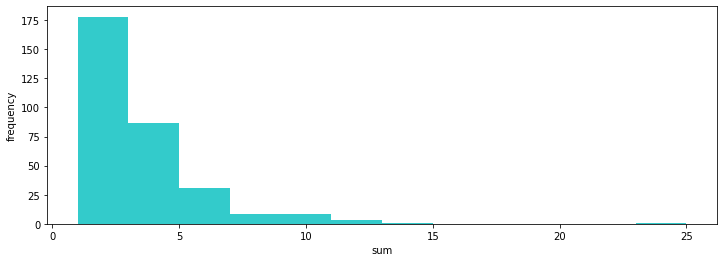

In [28]:
#疾患・症状のTFIDFがゼロより大きい値を取り出した時の可視化

plt.figure(figsize=(12,4))

#TFIDFの数
#plt.subplot(121)
each_disease_sum_vector = [sum(pivot_tfidf_df.loc[disease, :]>0) for disease in pivot_tfidf_df.index]
plt.hist(each_disease_sum_vector,color='c', bins=len(set(each_disease_sum_vector)), alpha=0.8)
plt.xlabel('sum')
plt.ylabel("frequency")
plt.show()

In [29]:
#コサイン類似度　計算

#コサイン算出用データフレームを作る
pre_cosine_df = tfidf.sort_values(['symptom', 'disease'])[['symptom', 'disease',"tf_idf"]].reset_index(drop=True)
pre_cosine_df = pd.pivot_table(pre_cosine_df, index='disease', columns='symptom', values="tf_idf")
pre_cosine_df = pre_cosine_df.fillna(0)#欠損値に0を入れる
#疾患個数
print(len(pre_cosine_df.index)) #1431


317


In [30]:
#疾患ペア(直積ペア)を作る
import itertools
product_list = list(itertools.product(pre_cosine_df.index, pre_cosine_df.index))
print(len(product_list))#2047761
print(product_list[0], product_list[1])

100489
('MESH:D000080984', 'MESH:D000080984') ('MESH:D000080984', 'MESH:D000081003')


In [31]:
#tfidf行列を疾患（＝行）ごとに分けて直積ペアを作る
vectors = [each_vectors for each_vectors in np.array(pre_cosine_df)]
vectors_list = list(itertools.product(vectors, vectors))

In [32]:
#コサイン類似度

#計算式
def cosine_similarity(x, y):#xとyはベクトルの成分
    return (np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y))))

#直積ペアにコサイン類似度計算を適用 
cosine_similarity_list = []
for disease_pair, vector in tqdm(zip( product_list, vectors_list )):
    cosine_similarity_list.append([disease_pair[0], disease_pair[-1], cosine_similarity(vector[0], vector[1])])

0it [00:00, ?it/s]

In [33]:
#データフレーム化
cosine_df = pd.DataFrame(cosine_similarity_list, columns=["disease_1", "disease_2", "cosine_similarity"])
cosine_df = cosine_df.sort_values("cosine_similarity", ascending=False).reset_index(drop=True)
pivot_cosine_df = cosine_df.pivot(index='disease_1', columns='disease_2', values='cosine_similarity')#.fillna(0)
print(len(cosine_df), len(pivot_cosine_df))
#2047761 1431

100489 317


In [34]:
#インデックスを取得
pivot_index = pivot_cosine_df.index.tolist()

In [35]:
#「同じ疾患同士」「順序が逆になっているだけで同じペアの片方」を削除

#アレイに変換
recent_array = np.array(pivot_cosine_df)

#下三角行列を取得する
#numpy.tril()の引数にnumpy.ndarrayを指定すると、対角線より上の成分をゼロとしたnumpy.ndarrayが返される。
#対角線のコサイン値＝１は不要なので、この対角線箇所も含めてゼロにしたい。
#numpy.tril()の第二引数のkで、境界となる対角線の位置が指定できる（正の値だと上側（右側）、負の値だと下側（左側）に移動する）

recent_array = np.tril(recent_array, k=-1) 

#データフレームにする　対角線含む上の値がゼロになっているか確認
repivot_cosine_df= pd.DataFrame(recent_array, index=pivot_cosine_df.index, columns=pivot_cosine_df.columns)
repivot_cosine_df[:5]
#1431 columns

disease_2,MESH:D000080984,MESH:D000081003,MESH:D000083143,MESH:D000130,MESH:D000141,MESH:D000326,MESH:D000361,MESH:D000474,MESH:D000742,MESH:D000755,...,MESH:D057826,MESH:D058247,MESH:D058494,MESH:D058495,MESH:D058496,MESH:D058540,MESH:D065627,MESH:D065635,MESH:D065708,MESH:D065766
disease_1,,,,,,,,,,,,,,,,,,,,,
MESH:D000080984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MESH:D000081003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MESH:D000083143,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MESH:D000130,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MESH:D000141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
repivot_cosine_df

disease_2,MESH:D000080984,MESH:D000081003,MESH:D000083143,MESH:D000130,MESH:D000141,MESH:D000326,MESH:D000361,MESH:D000474,MESH:D000742,MESH:D000755,...,MESH:D057826,MESH:D058247,MESH:D058494,MESH:D058495,MESH:D058496,MESH:D058540,MESH:D065627,MESH:D065635,MESH:D065708,MESH:D065766
disease_1,,,,,,,,,,,,,,,,,,,,,
MESH:D000080984,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
MESH:D000081003,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
MESH:D000083143,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
MESH:D000130,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
MESH:D000141,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MESH:D058540,0.0,0.0,0.0,0.312423,0.0,0.145849,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.524399,0.297437,0.133616,0.000000,0.0,0.0,0.0,0.0
MESH:D065627,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
MESH:D065635,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


In [37]:
#下三角行列のうち、コサイン値ゼロ以外の値の位置を取得
recent_array_index_list = [[value_0,
                            value_1] for value_0, value_1 in zip(list(np.where(recent_array>0)[0]),
                                                                 list(np.where(recent_array>0)[1]))]
print(len(recent_array_index_list)) #165320

9763


In [38]:
#元の（半分ゼロにする前の）行列で同じ位置を指定し、そのインデックス（疾患ペア）と値（コサイン値）を取得
#疾患a, 疾患b, abのコサイン値
repivot_pair = [ [pivot_index[i[0]],
                  pivot_index[i[1]], 
                  repivot_cosine_df.iloc[i[0], i[1]]] for i in tqdm(recent_array_index_list)]

# 作成されるデータは
#    「同じ疾患同士」「順序が逆になっただけの同じペアのうちの片方」「コサイン値ゼロ」これらを除いたデータ

  0%|          | 0/9763 [00:00<?, ?it/s]

In [39]:
hpo_cos = pd.DataFrame(repivot_pair, columns=["disease_1", "disease_2", "cosine_similarity"])

print("ds_pair数:", len(tfidf))
print("disease_MeSHの種類数:", len(repivot_cosine_df.index))
print("symptom_MeSHの種類数:", len(idf_n_i), "\n")

print("dd_pairの種類数(all):", len(hpo_cos))
print("dd_pairの種類数(O.1<cos):", len(hpo_cos[hpo_cos["cosine_similarity"]>0.1]))
print("dd_pairの種類数(O.2<cos):", len(hpo_cos[hpo_cos["cosine_similarity"]>0.2]))
print("dd_pairの種類数(O.5<cos):", len(hpo_cos[hpo_cos["cosine_similarity"]>0.5]), "\n")

print("---O.1<cos---")
cos1 = hpo_cos[hpo_cos["cosine_similarity"]>0.1]
print("dd_pairの種類数:", len(cos1))
print("disaease(MeSH)の種類数:", len(set(cos1["disease_1"].values.tolist() + cos1["disease_2"].values.tolist())))
print("0.1<cosでのcos_max:", cos1["cosine_similarity"].max())
print("0.1<cosでのcos_min:", cos1["cosine_similarity"].min(), "\n")

print("---O.1<cos<1---")
cos2 = hpo_cos[ (hpo_cos["cosine_similarity"]>0.1) & (hpo_cos["cosine_similarity"]<1)]
print("dd_pairの種類数:", len(cos2))
print("disaease(MeSH)の種類数:", len(set(cos2["disease_1"].values.tolist() + cos2["disease_2"].values.tolist())))
print("0.1<cos<1でのcos_max:", cos2["cosine_similarity"].max())
print("0.1<cos<1でのcos_min:", cos2["cosine_similarity"].min())

ds_pair数: 3368
disease_MeSHの種類数: 1431
symptom_MeSHの種類数: 165 

dd_pairの種類数(all): 165320
dd_pairの種類数(O.1<cos): 119282
dd_pairの種類数(O.2<cos): 84599
dd_pairの種類数(O.5<cos): 27339 

---O.1<cos---
dd_pairの種類数: 119282
disaease(MeSH)の種類数: 1424
0.1<cosでのcos_max: 1.0000000000000002
0.1<cosでのcos_min: 0.10002392265268653 

---O.1<cos<1---
dd_pairの種類数: 106525
disaease(MeSH)の種類数: 1422
0.1<cos<1でのcos_max: 0.9999999999999999
0.1<cos<1でのcos_min: 0.10002392265268653

In [40]:
print(len(hpo_cos))

9763


In [41]:
#hpo_cos MeSH表記修正

hpo_cos["disease_1_id"] = [i.replace("MESH:", '') for i in hpo_cos["disease_1"] ] 
hpo_cos["disease_2_id"] = [i.replace("MESH:", '') for i in hpo_cos["disease_2"] ] 
hpo_cos = hpo_cos[["disease_1_id", "disease_2_id", 'cosine_similarity'] ]
hpo_cos.set_axis(['disease_1', 'disease_2', 'cosine_similarity'], axis='columns', inplace=True)
hpo_cos[:3]

,disease_1,disease_2,cosine_similarity
0,D000326,D000130,0.045566
1,D000755,D000742,0.726524
2,D000795,D000130,0.031456


In [42]:
#HSDN読み込み
os.chdir('/home/admin_user/デスクトップ/data')
hsdn = pd.read_csv("hsdn.csv")#[["disease_1", "disease_2"]]

In [43]:
#MeSH 読込
os.chdir('/home/admin_user')
with open('mesh_list_2021.pickle', 'rb') as f:
    mesh_list = pickle.load(f)

#メッシュから　メッシュIDと疾患/症状メッシュ、TreeNumber を取り出す
#疾患メッシュ：Cのうち C22（動物)とC23.888（症状）を除外したもの）＋F03（精神障害）
#症状メッシュ：C23.888
mesh_diseases = [descriptor for descriptor in tqdm(mesh_list) for uid in descriptor[-1] if ((uid.startswith("C")==True) & (uid.startswith("C22")!=True)&(uid.startswith("C23.888")!=True)) | (uid.startswith("F03")==True) ]
mesh_symptoms = [descriptor for descriptor in tqdm(mesh_list)  for uid in descriptor[-1] if (uid.startswith("C23.888")==True)]
#さらにメッシュ名だけにする＋重複削除
mesh_diseases= pd.DataFrame(mesh_diseases)[1].drop_duplicates(keep='last').reset_index(drop=True).values.tolist()
mesh_symptoms= pd.DataFrame(mesh_symptoms)[1].drop_duplicates(keep='last').reset_index(drop=True).values.tolist()

len(mesh_list),len(mesh_diseases), len(mesh_symptoms)

  0%|          | 0/29917 [00:00<?, ?it/s]

  0%|          | 0/29917 [00:00<?, ?it/s]

(29917, 4887, 394)

In [44]:
#hsdnはメッシュ名のネットワークなので、メッシュIDのネットワークを作る

#id取り出し
mesh_disease_id = [ [s[0],s[1] ] for i in tqdm(mesh_diseases) for s in mesh_list if i ==s[1] ]

#mesh_id_hsdn([HSDN]) 作成
mesh_id_1 = pd.merge( pd.DataFrame(mesh_disease_id, columns=["mesh_id", "disease_1"]) , hsdn["disease_1"], how="right", on = "disease_1")
mesh_id_2 = pd.merge( pd.DataFrame(mesh_disease_id, columns=["mesh_id", "disease_2"]) , hsdn["disease_2"], how="right", on = "disease_2")


  0%|          | 0/4887 [00:00<?, ?it/s]

In [45]:
#MeSH_IDペアとコサイン類似度のデータフレームにする(=hsdn_cos)
HSDN = pd.concat([mesh_id_1["mesh_id"], mesh_id_2["mesh_id"]], axis=1)
hsdn_cos = pd.concat([HSDN, hsdn["cosine_similarity"]], axis=1)
hsdn_cos.set_axis(['disease_1', 'disease_2','cosine_similarity'], axis='columns', inplace=True)
print(len(hsdn_cos))

6313780


In [46]:
print(len(set(hpo_cos["disease_1"].unique().tolist()) | set(hpo_cos["disease_2"].unique().tolist())))

310


In [47]:
#エッジリスト読込・ネットワーク作成
import networkx as nx

#hsdn
hsdn_cos_G = nx.from_pandas_edgelist(hsdn_cos, "disease_1", "disease_2" )
#benchmark
hpo_cos_G = nx.from_pandas_edgelist( hpo_cos,"disease_1", "disease_2" )
print("hsdn_cos_G:", nx.info(hsdn_cos_G), "\n")
print("hpo_cos_G:", nx.info(hpo_cos_G), "\n")


hsdn_cos_G: Name: 
Type: Graph
Number of nodes: 4662
Number of edges: 6313780
Average degree: 2708.6143 

hpo_cos_G: Name: 
Type: Graph
Number of nodes: 310
Number of edges: 9763
Average degree:  62.9871 



In [48]:
#hsdn_cos_G, hpo_cos_G  共通ノード数: N
co_node = list(set([i for i in hsdn_cos_G.nodes()]) & set([i for i in hpo_cos_G.nodes()]))
N = len(co_node)
print("N:", N) #N: 305

N: 300


In [49]:
hsdn_co_node = sorted([i for i in hsdn_cos_G.degree()  if i[0] in co_node])
hpo_co_node = sorted([i for i in hpo_cos_G.degree()  if i[0] in co_node])
print(len(hsdn_co_node), len(hpo_co_node)) 

300 300


In [50]:
#あらかじめ、L_possible=N*(N-1)/2 を計算しておく
L_possible = N*(N - 1)/2
print("L_possible:", L_possible)

L_possible: 44850.0


In [51]:
print(hsdn_cos[:3], "\n", hpo_cos[:3])

  disease_1 disease_2  cosine_similarity
0   D000182   D058489           0.135159
1   D015526   D058165           0.100250
2   D015526   D058489           0.038676 
   disease_1 disease_2  cosine_similarity
0   D000326   D000130           0.045566
1   D000755   D000742           0.726524
2   D000795   D000130           0.031456


In [52]:
print(len(hsdn_cos),len(hpo_cos))

6313780 9763


In [53]:
#両者の共通部分のリンク数: L_both を求める

#共通ノードを同士のペアからなるネットワークに縮小
#Number of edges: 6313780
hsdn_cos_index = [ enu for enu, i in tqdm(enumerate(hsdn_cos.values.tolist())) if (i[0] in co_node) & (i[1] in co_node) ]
#Number of edges: 9763
hpo_cos_index = [ enu for enu, i in tqdm(enumerate(hpo_cos.values.tolist())) if (i[0] in co_node) & (i[1] in co_node) ]

hsdn_df = hsdn_cos.iloc[hsdn_cos_index].reset_index(drop=True)
hpo_df = hpo_cos.iloc[hpo_cos_index].reset_index(drop=True)

#HSDNでのリンク数を L_HSDN とする
L_HSDN = len(hsdn_df)
#HPOのリンク数を L_HPO とする
L_HPO = len(hpo_df)

print("L_HSDN:", L_HSDN)
print("L_HPO:", L_HPO)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

L_HSDN: 26482
L_HPO: 9330


In [54]:
#合わせる
same_dd_pair_1 = pd.merge(hsdn_df, hpo_df, on=["disease_1", "disease_2"])
same_dd_pair_1 = same_dd_pair_1.rename(columns={"cosine_similarity_x": "cosine_similarity_HSDN", "cosine_similarity_y": "cosine_similarity_hpo"})
print(len(same_dd_pair_1)) #4215

#順番を逆にして合わせる
hpo_df_rev = hpo_df[["disease_2", "disease_1", "cosine_similarity"]]
hpo_df_rev = hpo_df_rev.rename(columns={"disease_2":"disease_1", "disease_1":"disease_2"})

same_dd_pair_2 = pd.merge(hsdn_df, hpo_df_rev, on=["disease_1", "disease_2"])
same_dd_pair_2 = same_dd_pair_2.rename(columns={"cosine_similarity_x": "cosine_similarity_HSDN", "cosine_similarity_y": "cosine_similarity_hpo"})
print(len(same_dd_pair_2)) #2456

same_dd_pair = pd.concat([same_dd_pair_1, same_dd_pair_2], axis=0)
same_dd_pair = same_dd_pair.reset_index(drop=True)
print(len(same_dd_pair)) #6671

L_both = len(same_dd_pair)
print("L_both:", L_both)

4215
2456
6671
L_both: 6671


In [55]:
#p_HSDN=L_HSDN/L_possible を計算する
p_HSDN=L_HSDN/L_possible
#p_HPO=L_HPO/L_possible を計算する
p_HPO=L_HPO/L_possible 
print("p_HSDN:", p_HSDN)
print("p_HPO:", p_HPO)


p_HSDN: 0.5904570791527314
p_HPO: 0.2080267558528428


In [56]:
#p_HSDN * p_HPO * L_possible = L_expected を計算する
L_expected = p_HSDN * p_HPO * L_possible
print("L_expected:", L_expected)

#LL_expected: 5835.7387402933555

L_expected: 5508.964548494983


In [57]:
#二項分布Binom(n, p)を仮定して、 L_both が得られる確率 P-value を求める
#二項分布のn: L_possible
#二項分布のp: L_expected/L_possible 


In [58]:
print("N:", N)
print("L_possible:", L_possible)
print("L_HSDN:", L_HSDN)
print("L_HPO:", L_HPO)

print("p_HSDN:", p_HSDN)
print("p_HPO:", p_HPO)
print("L_both:", L_both)
print("L_expected:", L_expected)

from scipy import stats
stats.binom_test(L_both, 
                 n=L_possible, 
                 p=L_expected/L_possible, 
                 alternative='greater')
#scipy.stats.binom_test(x, n=None, p=0.5, alternative='two-sided')[source]
#x = The number of successes
#n = The number of trials.
#p = The hypothesized probability of success 
#alternative = The default value is ‘two-sided’.


N: 300
L_possible: 44850.0
L_HSDN: 26482
L_HPO: 9330
p_HSDN: 0.5904570791527314
p_HPO: 0.2080267558528428
L_both: 6671
L_expected: 5508.964548494983


1.1540223686474666e-59

In [59]:
#Zhou
Zhou_N = 898
Zhou_L_possible = 402753
Zhou_L_HSDN = 372509
Zhou_L_HPO = 111923
Zhou_p_HSDN = Zhou_L_HSDN/Zhou_L_possible
Zhou_p_HPO = Zhou_L_HPO/Zhou_L_possible
Zhou_L_both = 107098
Zhou_L_expected = Zhou_p_HSDN * Zhou_p_HPO * Zhou_L_possible

print("Zhou_N:", Zhou_N)
print("Zhou_L_possible:", Zhou_L_possible)
print("Zhou_L_HSDN:", Zhou_L_HSDN)
print("Zhou_L_HPO:", Zhou_L_HPO)
print("Zhou_p_HSDN:", Zhou_p_HSDN)
print("Zhou_p_HPO:", Zhou_p_HPO)
print("Zhou_L_both:", Zhou_L_both)
print("Zhou_L_expected:", Zhou_L_expected)

stats.binom_test(Zhou_L_both, 
                 n=Zhou_L_possible, 
                 p=Zhou_L_expected/Zhou_L_possible, 
                 alternative='greater')
#Zhou et al., (2014)ではP-value = 2.2 × 10-16 
#alternative='greater' 3.8610006936573684e-38
#alternative='less' 0.9999999999999999
#alternative='two-sided' 7.665251007753277e-38

Zhou_N: 898
Zhou_L_possible: 402753
Zhou_L_HSDN: 372509
Zhou_L_HPO: 111923
Zhou_p_HSDN: 0.9249068287511204
Zhou_p_HPO: 0.2778948884303779
Zhou_L_both: 107098
Zhou_L_expected: 103518.34699431164


3.8610006936573684e-38

In [60]:
Zhou_L_expected/Zhou_L_possible

0.25702687998428725

In [63]:
#HSDN＝１のとき（ペア1個だけしかない）
for i in same_dd_pair[same_dd_pair["cosine_similarity_HSDN"]==1].values.tolist():
    for mesh_0 in mesh_list:
        if i[0] == mesh_0[0]:
            for mesh_1 in mesh_list:
                 if i[1] == mesh_1[0]:
                        print(mesh_0)
                        print(mesh_1)
                        print(i[-3:])

['D052517', 'Multiple Sulfatase Deficiency Disease', ['C10.228.140.163.100.435.825.850.750', 'C16.320.565.189.435.825.850.750', 'C16.320.565.398.641.803.925.750', 'C16.320.565.595.554.825.850.750', 'C18.452.132.100.435.825.850.750', 'C18.452.584.687.803.925.750', 'C18.452.648.189.435.825.850.750', 'C18.452.648.398.641.803.925.750', 'C18.452.648.595.554.825.850.750']]
['D054880', 'Aspartylglucosaminuria', ['C16.320.565.595.100', 'C18.452.648.595.100']]
['D054880', 1.0, 0.2022990290225083]


In [64]:
#HPO＝１のときにHSDNが最も離れているもの
for i in same_dd_pair[same_dd_pair["cosine_similarity_hpo"]==1].sort_values("cosine_similarity_HSDN")[:1].values.tolist():
    for mesh_0 in mesh_list:
        if i[0] == mesh_0[0]:
            for mesh_1 in mesh_list:
                 if i[1] == mesh_1[0]:
                        print(mesh_0)
                        print(mesh_1)
                        print(i[-3:])

['D010381', 'Pelger-Huet Anomaly', ['C15.378.553.696', 'C16.320.784']]
['D009456', 'Neurofibromatosis 1', ['C04.557.580.600.580.590.650', 'C04.700.631.650', 'C10.562.600.500', 'C10.574.500.549.400', 'C10.668.829.675', 'C16.320.400.560.400', 'C16.320.700.633.650']]
['D009456', 0.0012974556170318, 1.0]


In [65]:
#HPO＝１のときにHSDNが最も近いもの
for i in same_dd_pair[same_dd_pair["cosine_similarity_hpo"]==1].sort_values("cosine_similarity_HSDN")[-1:].values.tolist():
    for mesh_0 in mesh_list:
        if i[0] == mesh_0[0]:
            for mesh_1 in mesh_list:
                 if i[1] == mesh_1[0]:
                        print(mesh_0)
                        print(mesh_1)
                        print(i[-3:])

['D007566', 'Jaundice, Chronic Idiopathic', ['C16.320.565.300.764', 'C16.614.451.500.250', 'C18.452.648.300.764']]
['D005878', 'Gilbert Disease', ['C16.320.565.300.528', 'C18.452.648.300.528']]
['D005878', 0.9862210487828772, 1.0]


In [78]:
same_dd_pair[:5]

,disease_1,disease_2,cosine_similarity_HSDN,cosine_similarity_hpo,cosine_diff
0,D055673,D000130,0.089330,0.131298,0.041969
1,D000326,D000130,0.056525,0.045566,0.010958
2,D058540,D000130,0.147486,0.312423,0.164936
3,D058540,D055673,0.168636,0.420259,0.251623
4,D058540,D000326,0.170056,0.145849,0.024208


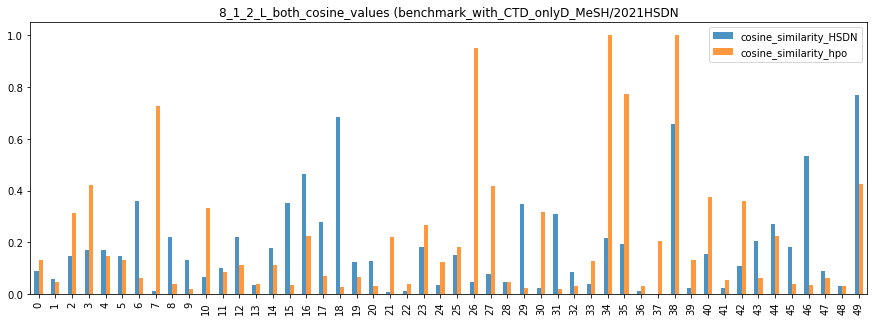

In [83]:
same_dd_pair[["cosine_similarity_HSDN", "cosine_similarity_hpo"]][:50].plot.bar(figsize=(15, 5), alpha=0.8, 
                                                                                title="8_1_2_L_both_cosine_values (benchmark_with_CTD_onlyD_MeSH/2021HSDN")
plt.show()

In [67]:
same_dd_pair["cosine_diff"] = None
for enu, i in tqdm(enumerate(same_dd_pair["cosine_similarity_HSDN"]-same_dd_pair["cosine_similarity_hpo"])):
    if i<0:
        same_dd_pair.loc[:, 'cosine_diff'][enu] = -i
    else:
        same_dd_pair.loc[:, 'cosine_diff'][enu] = i

0it [00:00, ?it/s]

<ipython-input-67-fc0ce0f34623>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_dd_pair.loc[:, 'cosine_diff'][enu] = -i
<ipython-input-67-fc0ce0f34623>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  same_dd_pair.loc[:, 'cosine_diff'][enu] = i


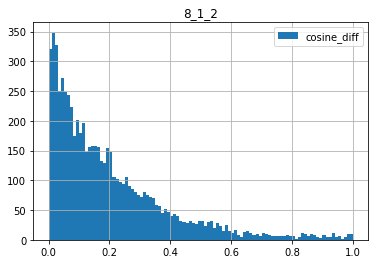

In [86]:
same_dd_pair["cosine_diff"].hist(bins=100, legend="True")
plt.title('8_1_2') 
plt.show()

In [74]:
#コサイン値の差が最大のもの
for i in same_dd_pair.sort_values("cosine_diff", ascending=False)[:1].values.tolist():
    for mesh_0 in mesh_list:
        if i[0] == mesh_0[0]:
            for mesh_1 in mesh_list:
                 if i[1] == mesh_1[0]:
                        print(mesh_0)
                        print(mesh_1)
                        print(i)

['D010381', 'Pelger-Huet Anomaly', ['C15.378.553.696', 'C16.320.784']]
['D009456', 'Neurofibromatosis 1', ['C04.557.580.600.580.590.650', 'C04.700.631.650', 'C10.562.600.500', 'C10.574.500.549.400', 'C10.668.829.675', 'C16.320.400.560.400', 'C16.320.700.633.650']]
['D010381', 'D009456', 0.0012974556170318, 1.0, 0.9987025443829682]


In [75]:
#コサイン値の差が最小のもの
for i in same_dd_pair.sort_values("cosine_diff", ascending=False)[-1:].values.tolist():
    for mesh_0 in mesh_list:
        if i[0] == mesh_0[0]:
            for mesh_1 in mesh_list:
                 if i[1] == mesh_1[0]:
                        print(mesh_0)
                        print(mesh_1)
                        print(i)

['D017118', 'Porphyria, Acute Intermittent', ['C06.552.830.150', 'C16.320.850.742.150', 'C17.800.827.742.150', 'C18.452.811.400.150']]
['D052556', 'Niemann-Pick Disease, Type C', ['C10.228.140.163.100.435.825.700.875', 'C15.604.250.410.625.875', 'C16.320.565.189.435.825.700.875', 'C16.320.565.398.641.803.730.875', 'C16.320.565.595.554.825.700.875', 'C18.452.132.100.435.825.700.875', 'C18.452.584.687.803.730.875', 'C18.452.648.189.435.825.700.875', 'C18.452.648.398.641.803.730.875', 'C18.452.648.595.554.825.700.875']]
['D017118', 'D052556', 0.0257720568323063, 0.025781982763290346, 9.925930984047704e-06]


In [71]:
print(len(set(same_dd_pair["disease_1"].unique().tolist()) | set(same_dd_pair["disease_2"].unique().tolist())))

299


In [72]:
same_pair_G = nx.from_pandas_edgelist( same_dd_pair,"disease_1", "disease_2" )
print("same_pair_G:", nx.info(same_pair_G), "\n")

same_pair_G: Name: 
Type: Graph
Number of nodes: 299
Number of edges: 6671
Average degree:  44.6221 



8-1-2: L_both 6671


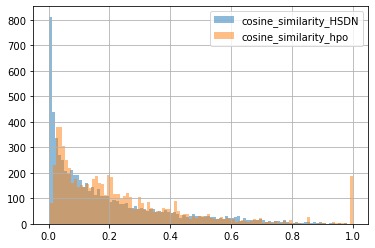

In [73]:
print("8-1-2: L_both", len(same_dd_pair))
same_dd_pair["cosine_similarity_HSDN"].hist(bins=100, alpha=0.5, legend="True")
same_dd_pair["cosine_similarity_hpo"].hist(bins=100, alpha=0.5, legend="True")
plt.show()